In [40]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
from IPython.display import Audio
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow.keras.layers as L
from tensorflow.keras.layers import Dense 
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Dataset

In [41]:
path = "../speech_emotion_dataset"
# audio_dir = "./Crema"

In [42]:
def load_and_listen(audio_path, sample_rate=22050):
    # Load the audio
    y, sr = librosa.load(audio_path, sr=sample_rate)

    # Plot the waveform
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform of {audio_path}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

    # Play the audio
    return Audio(y, rate=sr)


Total audio files: 7442


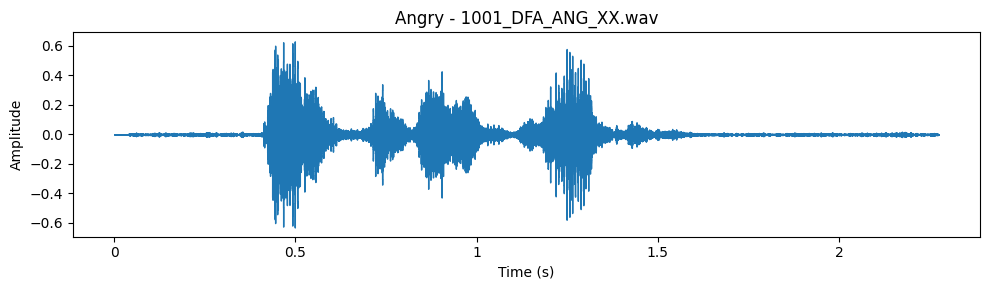

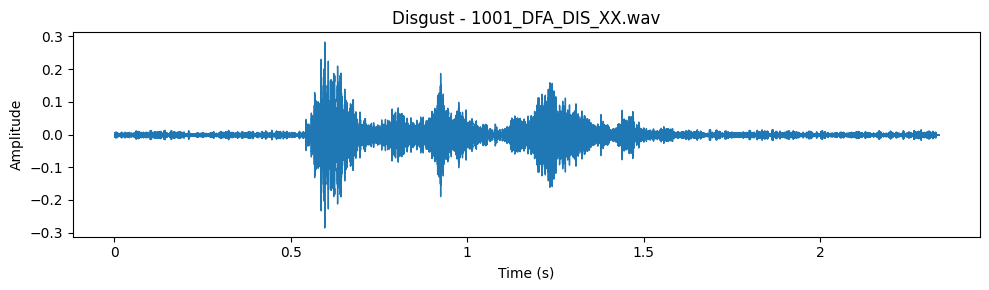

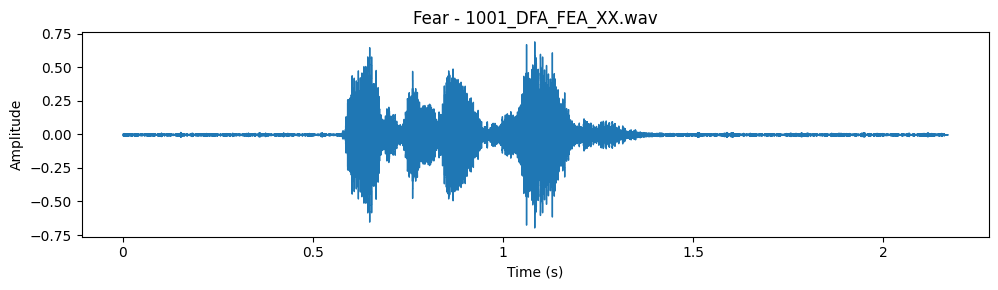

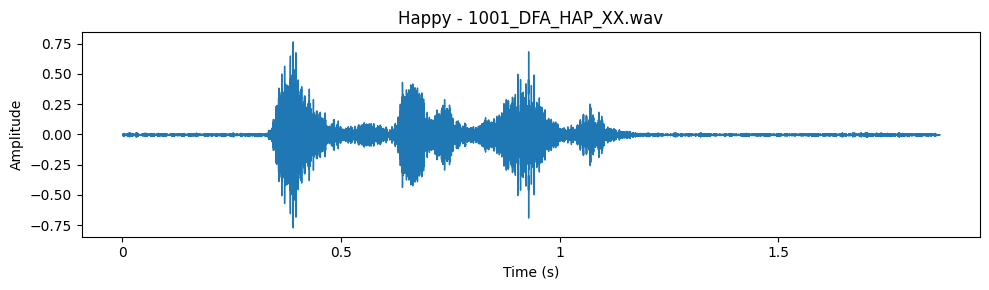

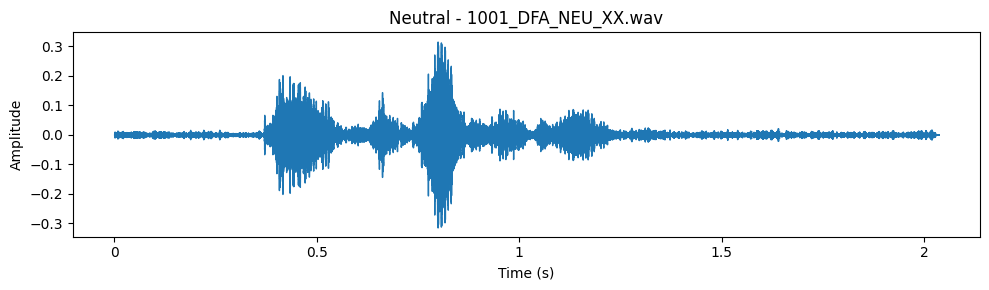

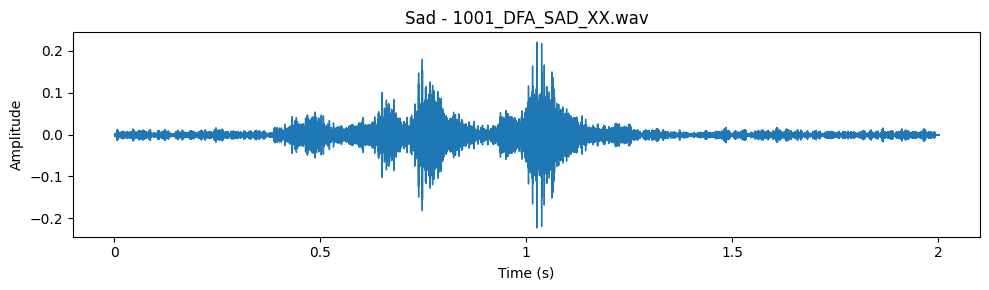

In [43]:
# Locate the folder with .wav files
audio_dir = os.path.join(path, "Crema")  # Make sure this folder name matches what you see

# List all .wav files
audio_files = [f for f in os.listdir(audio_dir) if f.endswith(".wav")]
print(f"Total audio files: {len(audio_files)}")

# Mapping of emotion codes to labels
emotion_map = {
    "ANG": "Angry",
    "DIS": "Disgust",
    "FEA": "Fear",
    "HAP": "Happy",
    "NEU": "Neutral",
    "SAD": "Sad"
}

# Extract a sample of one file per emotion
samples = {}
for file in audio_files:
    parts = file.split('_')
    emotion_code = parts[2]
    if emotion_code in emotion_map and emotion_code not in samples:
        samples[emotion_code] = file

# Plot and listen to one file per emotion
for code, filename in samples.items():
    filepath = os.path.join(audio_dir, filename)
    signal, sr = librosa.load(filepath, sr=None)
    
    # Plot waveform
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(signal, sr=sr)
    plt.title(f"{emotion_map[code]} - {filename}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()
    
    # Play audio (if running in Jupyter Notebook)
    try:
        from IPython.display import Audio, display
        display(Audio(filepath))
    except:
        pass

### Data Augmentation

In [ ]:
def add_noise(data, random=False, rate=0.035, threshold=0.075):
    if random:
        rate = np.random.random() * threshold
    # noise = rate * np.random.uniform() * np.amax(data)
    noise = rate * np.amax(data) * np.random.normal(0, 1, size=data.shape)
    augmented_data = data + noise * np.random.normal(size=data.shape[0])
    return augmented_data

def shifting(data, rate=1000, wrap=False):
    shift_amount = int(np.random.uniform(low=-5, high=5) * rate)
    if wrap:
        return np.roll(data, shift_amount)
    else:
        if shift_amount > 0:
            return np.concatenate((np.zeros(shift_amount), data[:-shift_amount]))
        else:
            return np.concatenate((data[-shift_amount:], np.zeros(-shift_amount)))


def pitching(y, sr, n_steps=4):
    y_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
    return y_shifted

def stretching(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)


In [72]:
def extract_features(filepath, sr=16000, frame_length=2048, hop_length=512, n_mels=128, augment = False):
    # Load audio
    signal, sr = librosa.load(filepath, sr=sr)  # Use desired sampling rate
    # Trim silent edges
    signal, _ = librosa.effects.trim(signal)
    
    if augment:
        # Randomly choose one augmentation (or apply all if desired)
        aug_type = np.random.choice(['noise', 'shift', 'pitch', 'stretch'])
        if aug_type == 'noise':
            signal = add_noise(signal, random=True)
        elif aug_type == 'shift':
            signal = shifting(signal)
        elif aug_type == 'pitch':
            signal = pitching(signal, sr)
        elif aug_type == 'stretch':
            try:
                signal = stretching(signal, rate=np.random.uniform(0.8, 1.2))
            except:
                pass  # stretching can sometimes result in shape mismatch    

    # --- Zero Crossing Rate ---
    zcr = librosa.feature.zero_crossing_rate(
        y=signal, frame_length=frame_length, hop_length=hop_length
    )[0]  # shape: (frames,)

    # --- Energy (normalized) ---
    energy = np.array([
        np.sum(signal[i:i+frame_length]**2) / frame_length
        for i in range(0, len(signal) - frame_length + 1, hop_length)
    ])
    
    # --- Mel Spectrogram ---
    mel_spec = librosa.feature.melspectrogram(
        y=signal, sr=sr, n_mels=n_mels,
        n_fft=frame_length, hop_length=hop_length
    )

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    return zcr, energy, mel_spec_db

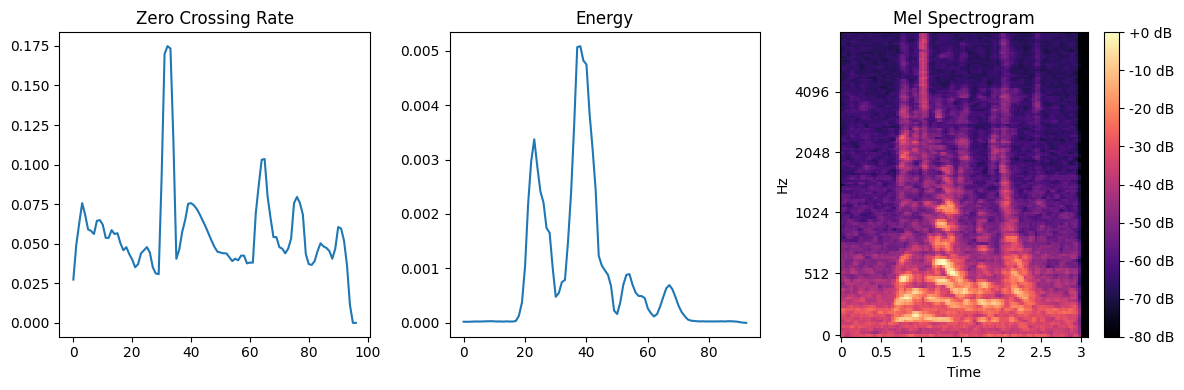

In [73]:
# Test on a sample
test_file = os.path.join(audio_dir, random.choice(audio_files))
zcr, energy, mel_spec = extract_features(test_file, augment=True)
fs1 = zcr , energy
fs2 = mel_spec
# Plot features
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(zcr)
plt.title("Zero Crossing Rate")

plt.subplot(1, 3, 2)
plt.plot(energy)
plt.title("Energy")

plt.subplot(1, 3, 3)
librosa.display.specshow(mel_spec, sr=16000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")

plt.tight_layout()
plt.show()

In [74]:
# Prepare containers
zcr_list = []
energy_list = []
mel_spec_list = []
labels = []

valid_emotions = {"ANG", "DIS", "FEA", "HAP", "NEU", "SAD"}

# Loop through files
for file in tqdm(audio_files):
    parts = file.split('_')
    emotion_code = parts[2]

    if emotion_code not in valid_emotions:
        continue 

    filepath = os.path.join(audio_dir, file)
    
    try:
        # Original (non-augmented) data
        zcr, energy, mel_spec = extract_features(filepath, augment=False)
        zcr_list.append(zcr)
        energy_list.append(energy)
        mel_spec_list.append(mel_spec)
        labels.append(emotion_code)

        # Augmented version (1 sample per original)
        zcr_aug, energy_aug, mel_spec_aug = extract_features(filepath, augment=True)
        zcr_list.append(zcr_aug)
        energy_list.append(energy_aug)
        mel_spec_list.append(mel_spec_aug)
        labels.append(emotion_code)  # Same label
        
    except Exception as e:
        print(f"Failed for {file}: {e}")

100%|██████████| 7442/7442 [02:46<00:00, 44.74it/s]


In [75]:
X =zcr_list, energy_list, mel_spec_list
print(len(zcr_list), len(energy_list), len(mel_spec_list))

le = LabelEncoder()
label_array = le.fit_transform(labels)

# Get mapping
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_map)
label_array.shape
print(label_array.shape)

# Convert to DataFrame
df = pd.DataFrame({
    'zcr': zcr_list,
    'energy': energy_list,
    'mel_spec': mel_spec_list,
    'label': label_array
})

X = df.drop(columns=['label'])
y = df['label']

print("Shape of features:", X.shape)
print("Shape of labels:", y.shape)


14884 14884 14884
Label mapping: {np.str_('ANG'): np.int64(0), np.str_('DIS'): np.int64(1), np.str_('FEA'): np.int64(2), np.str_('HAP'): np.int64(3), np.str_('NEU'): np.int64(4), np.str_('SAD'): np.int64(5)}
(14884,)
Shape of features: (14884, 3)
Shape of labels: (14884,)


### Splitting the data

In [76]:
# 1. Train+Val (70%) and Test (30%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

# 2. From Train+Val, get 5% as validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.05,  # 5% of 70% ≈ 3.5% of total data
    stratify=y_temp,
    random_state=42
)

# Show shapes
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (9897, 3)
Validation shape: (521, 3)
Test shape: (4466, 3)


### Create the feature space

In [77]:
"""First feature Space""" 
X_train1 = X_train[X_train.columns[0:2]]
X_val1   = X_val[X_val.columns[0:2]]
X_test1  = X_test[X_test.columns[0:2]]

"""Second feature space"""
X_train2 = X_train[X_train.columns[2:]]
X_val2   = X_val[X_val.columns[2:]]
X_test2  = X_test[X_test.columns[2:]]

print("Train shape1:", X_train1.shape)
print("Validation shape1:", X_val1.shape)
print("Test shape1:", X_test1.shape)

print("Train shape2:", X_train2.shape)
print("Validation shape2:", X_val2.shape)
print("Test shape2:", X_test2.shape)

Train shape1: (9897, 2)
Validation shape1: (521, 2)
Test shape1: (4466, 2)
Train shape2: (9897, 1)
Validation shape2: (521, 1)
Test shape2: (4466, 1)


### Prepare Data for Model Input

In [114]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad 1D features
def stack_and_pad_1d(features1, features2, max_len=400):
    x1 = pad_sequences(features1, maxlen=max_len, padding='post', dtype='float32')
    x2 = pad_sequences(features2, maxlen=max_len, padding='post', dtype='float32')
    return np.concatenate([x1, x2], axis=-1)

X_train1_padded = stack_and_pad_1d(X_train1['zcr'], X_train1['energy'])
X_val1_padded = stack_and_pad_1d(X_val1['zcr'], X_val1['energy'])
X_test1_padded = stack_and_pad_1d(X_test1['zcr'], X_test1['energy'])

# Pad 2D mel spectrograms
def pad_melspec_2d(mels, max_time=400, max_freq=None):
    padded = []
    for m in mels:
        # Determine the frequency dimension size if not provided
        if max_freq is None:
            max_freq = m.shape[0]
        
        # Pad time dimension
        if m.shape[1] < max_time:
            pad_width_time = max_time - m.shape[1]
            m_padded = np.pad(m, ((0, 0), (0, pad_width_time)), mode='constant')
        else:
            m_padded = m[:, :max_time]
        
        # Pad frequency dimension if necessary
        if m.shape[0] < max_freq:
            pad_width_freq = max_freq - m.shape[0]
            m_padded = np.pad(m_padded, ((0, pad_width_freq), (0, 0)), mode='constant')
        else:
            m_padded = m_padded[:max_freq, :]
        
        padded.append(m_padded)
    
    return np.array(padded)[..., np.newaxis]  # Add channel dimension for 2D CNNs

# Apply the function to pad mel spectrograms
X_train2_padded = pad_melspec_2d(X_train2['mel_spec'])
X_val2_padded = pad_melspec_2d(X_val2['mel_spec'])
X_test2_padded = pad_melspec_2d(X_test2['mel_spec'])

# Convert labels
y_train_arr = tf.keras.utils.to_categorical(y_train)
y_val_arr = tf.keras.utils.to_categorical(y_val)
y_test_arr = tf.keras.utils.to_categorical(y_test)

# Print shapes to verify
print("Train shape:", X_train1_padded.shape)
print("Validation shape:", X_val1_padded.shape)
print("Test shape:", X_test1_padded.shape)

print("Train 2D shape:", X_train2_padded.shape)
print("Validation 2D shape:", X_val2_padded.shape)
print("Test 2D shape:", X_test2_padded.shape)

Train shape: (9897, 800)
Validation shape: (521, 800)
Test shape: (4466, 800)
Train 2D shape: (9897, 128, 400, 1)
Validation 2D shape: (521, 128, 400, 1)
Test 2D shape: (4466, 128, 400, 1)


## Define CNN Models

### 1D CNN (ZCR + Energy)

In [130]:
def build_1d_cnn(input_shape, num_classes):
    # model = tf.keras.Sequential([
    #     tf.keras.layers.Input(shape=input_shape),
    #     tf.keras.layers.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'),
    #     tf.keras.layers.BatchNormalization(),
    #     tf.keras.layers.MaxPooling1D(pool_size=5,strides=2,padding='same'),
    #     tf.keras.layers.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'),
    #     tf.keras.layers.BatchNormalization(),
    #     tf.keras.layers.MaxPooling1D(pool_size=5,strides=2,padding='same'),
    #     tf.keras.layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    #     tf.keras.layers.BatchNormalization(),
    #     tf.keras.layers.MaxPooling1D(pool_size=5,strides=2,padding='same'),
    #     tf.keras.layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    #     tf.keras.layers.BatchNormalization(),
    #     tf.keras.layers.MaxPooling1D(pool_size=5,strides=2,padding='same'),
    #     tf.keras.layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
    #     tf.keras.layers.BatchNormalization(),
    #     tf.keras.layers.MaxPooling1D(pool_size=5,strides=2,padding='same'),
    #     tf.keras.layers.Flatten(),
    #     tf.keras.layers.Dense(512, activation='relu'),
    #     tf.keras.layers.Dense(num_classes, activation='softmax')
    # ])
    model=tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(800,1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(6,activation='softmax')
])
    return model


### 2D CNN (Mel Spectrogram)

In [131]:
def build_2d_cnn(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(512, (5, 5), strides=1, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(5, 5),strides=2,padding='same'),
        tf.keras.layers.Conv2D(512, (5, 5), strides=1, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(5, 5),strides=2,padding='same'),
        tf.keras.layers.Conv2D(256, (5, 5), strides=1, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(5, 5),strides=2,padding='same'),
        tf.keras.layers.Conv2D(256, (5, 5), strides=1, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(5, 5),strides=2,padding='same'),
        tf.keras.layers.Conv2D(128, (5, 5), strides=1, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(5, 5),strides=2,padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model


### Train the 1D CNN Model

In [132]:
callbacks = [
    EarlyStopping(monitor= 'val_accuracy', patience=5, restore_best_weights=True, mode ='auto'),
    ReduceLROnPlateau(monitor='val_accuracy',patience=5)
]

print(X_train1_padded.shape, X_train1_padded.dtype)

(9897, 800) float32


In [1]:
scaler = StandardScaler()
X_train1_scaled = scaler.fit_transform(X_train1_padded)
X_val1_scaled = scaler.transform(X_val1_padded)
X_test1_scaled = scaler.transform(X_test1_padded)


NameError: name 'StandardScaler' is not defined

In [134]:
print(X_train1_scaled[0].shape, X_train1_scaled[0].dtype)
print(X_train1_scaled[1].shape, X_train1_scaled[1].dtype)

(800,) float32
(800,) float32


In [135]:
# Train 1D CNN
model_1d = build_1d_cnn(X_train1_scaled.shape[1:], 6)
model_1d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_1d.summary()
history_1D = model_1d.fit(X_train1_scaled, y_train_arr, epochs=50, batch_size=32, 
             validation_data=(X_val1_scaled, y_val_arr), callbacks=callbacks)

c:\Users\Kimo Store\anaconda3\envs\pr\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_35 (Conv1D)              │ (None, 800, 512)       │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 800, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_35 (MaxPooling1D) │ (None, 400, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ (None, 400, 512)       │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 400, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_36 (MaxPooling1D) │ (None, 200, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ (None, 200, 256)       │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 200, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_37 (MaxPooling1D) │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_38 (Conv1D)              │ (None, 100, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 100, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_38 (MaxPooling1D) │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 50, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_39 (MaxPooling1D) │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,915,910 (14.94 MB)

 Trainable params: 3,911,558 (14.92 MB)

 Non-trainable params: 4,352 (17.00 KB)

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 211s 669ms/step - accuracy: 0.3517 - loss: 1.7268 - val_accuracy: 0.1708 - val_loss: 14.1951 - learning_rate: 0.0010
Epoch 2/50
 11/310 ━━━━━━━━━━━━━━━━━━━━ 3:14 651ms/step - accuracy: 0.3886 - loss: 1.5020

KeyboardInterrupt: 

### Train the 2D CNN Model

In [ ]:
# Train 2D CNN
model_2d = build_2d_cnn(X_train2_padded.shape[1:], 6)
model_2d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2d.summary()
history_2D = model_2d.fit(X_train2_padded, y_train_arr, epochs=30, batch_size=32, 
             validation_data=(X_val2_padded, y_val_arr), callbacks=callbacks)


## Models Evaluation

Train accuracy 1D: [0.25363782048225403, 0.31386420130729675, 0.3211398422718048, 0.34377527236938477, 0.3468067944049835, 0.35226354002952576, 0.3609539270401001, 0.3726758360862732, 0.37388843297958374, 0.3605497181415558, 0.36358124017715454, 0.3712611198425293, 0.3712611198425293, 0.3833872377872467]
Validation accuracy 1D: [0.16858237981796265, 0.16858237981796265, 0.16858237981796265, 0.2298850566148758, 0.26436781883239746, 0.27969348430633545, 0.2375478893518448, 0.17624521255493164, 0.3295019268989563, 0.20306512713432312, 0.3295019268989563, 0.17241379618644714, 0.30651339888572693, 0.26436781883239746]


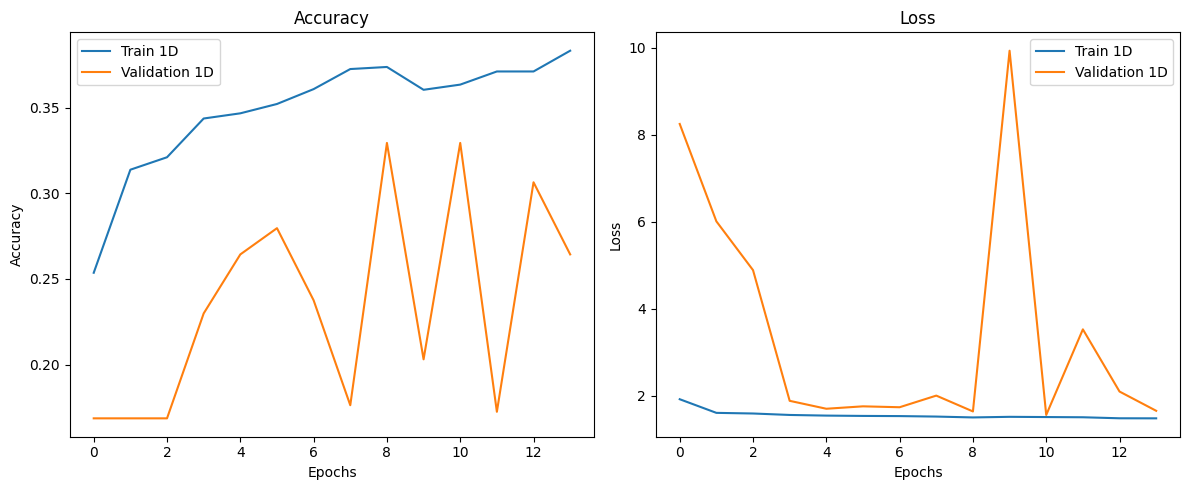

In [ ]:
# train accuracy
train_acc_1d = history_1D.history['accuracy']
# train_acc_2d = history_2D.history['accuracy']
# validation accuracy
val_acc_1d = history_1D.history['val_accuracy']
# val_acc_2d = history_2D.history['val_accuracy']
# train loss
train_loss_1d = history_1D.history['loss']
# train_loss_2d = history_2D.history['loss']
# validation loss
val_loss_1d = history_1D.history['val_loss']
# val_loss_2d = history_2D.history['val_loss']

print("Train accuracy 1D:", train_acc_1d)
print("Validation accuracy 1D:", val_acc_1d)

# print("Train accuracy 2D:", train_acc_2d)
# print("Validation accuracy 2D:", val_acc_2d)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_1d, label='Train 1D')
plt.plot(val_acc_1d, label='Validation 1D')
# plt.plot(train_acc_2d, label='Train 2D')
# plt.plot(val_acc_2d, label='Validation 2D')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_loss_1d, label='Train 1D')
plt.plot(val_loss_1d, label='Validation 1D')
# plt.plot(train_loss_2d, label='Train 2D')
# plt.plot(val_loss_2d, label='Validation 2D')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
